# Using Python for subsurface petrophysical analysis

Today we'll go over some nice examples of boosting subsurface workflows with petrophysical and facies analysis in Python. There are so many things that can be done but these two examples are great ways to start working with well log data and also really highlight the power of Python for:
- simplicity
- visualizations
- repeability

And how Python benefits from a wide user base that develops libraries, workflows, and functions that we can re-use!

Let's import some packages and mount our drive

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive #mounting drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Petrophsyical equation functions
We want to run some petrophysical analyses on our data, in particular let's calculate things like:
- Vshale using a the IGR linear equation. 
- Density Porosity
- Archie Sw

We'll define these as functions at the beginning of our code and then use them later one. Defining them here allows us to call them later very quickly.

Again these functions can be reused in your own future work, not just in this notebook! You simply copy them over (some people like this option best) or you save individual functions as .py files (some people prefer option 2)

Let's define those functions:

In [68]:
#Let's define a simple shale volume equation. Linear assumption
def volshale(gamma_ray, gamma_ray_max, gamma_ray_min): #We'll use the paramters for the GR value and the min and max of the GR
    vshale = (gamma_ray - gamma_ray_min) / (gamma_ray_max - gamma_ray_min)
    return round(vshale, 4)

#Let's define a simple shale volume equation.
def density_porosity(input_density, matrix_density, fluid_density):
    denpor = (matrix_density - input_density) / (matrix_density - fluid_density)
    return round(denpor, 4)

#Let's define a simple shale volume equation.
def sw_archie(porosity, rt, rw, archieA, archieM, archieN):
    sw = ((archieA / (porosity ** archieM)) * (rw/rt))**(1/archieN)
    return sw

### Load and transform data using petrophysical functions

We're going to load some data from a csv that's been prepared already. You could load data from Las files with `Lasio` or `Welly` too but as you'll see, we'll send the data to a `pandas` dataframe because it makes working with data so much easier! All these results could be send back to an las file no problem!

In [69]:
# Let's load a well
well = pd.read_csv(r"gdrive/My Drive/Data/15_9-19.csv", header=0, skiprows=[1])
well.replace(-999.00, np.nan, inplace=True) #repace -999 values with NaNs. In place locks the replacement in rather than making it temporary
well.head()

DEPTH   CALI  COAL       DT   DT_LOG       DTS   DTS_LOG      GR  \
0  3500.0183  9.315   0.0  76.7292  76.7292  157.1754  157.1754  36.621   
1  3500.1707  9.324   0.0  77.2473  77.2473  158.9566  158.9566  36.374   
2  3500.3231  9.338   0.0  77.8462  77.8462  159.7642  159.7642  30.748   
3  3500.4755  9.329   0.0  78.3571  78.3571  158.7547  158.7547  29.795   
4  3500.6279  9.328   0.0  78.6560  78.6560  157.1320  157.1320  27.346   

     NPHI    PHIE   PHIEC    PHIT   PHITC    RHOB  RHOB_LOG     RT      RW  \
0  0.1542  0.1122  0.1098  0.1209  0.1186  2.4602     2.460  1.791  0.0211   
1  0.1694  0.1074  0.1060  0.1159  0.1146  2.4680     2.468  1.756  0.0211   
2  0.1776  0.1082  0.1079  0.1127  0.1125  2.4730     2.473  1.720  0.0211   
3  0.1767  0.1254  0.1226  0.1292  0.1264  2.4471     2.447  1.696  0.0211   
4  0.1662  0.1278  0.1249  0.1299  0.1270  2.4460     2.446  1.697  0.0211   

      TEMP  
0  94.5855  
1  94.5897  
2  94.5940  
3  94.5982  
4  94.6025

Now that we've loaded data into a dataframe, let's create new columns (like VSHALE) that use the functions we define earlier!

All we need to do is say we want to create a column, name it, and say the contents should be the function we want to run, with the paramters that should be used to run it!

In [70]:
#Create new VSHALE column using the function we defined
well['VSHALE'] = volshale(well['GR'], well['GR'].quantile(q=0.99), well['GR'].quantile(q=0.01)) #using quantiles instead of max and min/ using the quantiles, q=99 means 99% of values lie below this (helps if there are erroneous values)

#Calculate density porosity
well['PHI'] = density_porosity(well['RHOB'], 2.65, 1)

#Calculate PHIE
well['PHIECALC'] = well['PHI'] - (well['VSHALE'] * 0.3) # The 0.3 is a scalar assumption about the relationship of porosity and shale

#Calculate Archie SW
well['SW'] = sw_archie(well['PHI'], well['RT'], well['RW'], 1, 2, 2) #calculating our Archie SW and using our curves as well as scalars

#Limit SW to 1
well['SW_LIM'] = well['SW'].mask(well['SW']>1, 1)

well.head()


DEPTH   CALI  COAL       DT   DT_LOG       DTS   DTS_LOG      GR  \
0  3500.0183  9.315   0.0  76.7292  76.7292  157.1754  157.1754  36.621   
1  3500.1707  9.324   0.0  77.2473  77.2473  158.9566  158.9566  36.374   
2  3500.3231  9.338   0.0  77.8462  77.8462  159.7642  159.7642  30.748   
3  3500.4755  9.329   0.0  78.3571  78.3571  158.7547  158.7547  29.795   
4  3500.6279  9.328   0.0  78.6560  78.6560  157.1320  157.1320  27.346   

     NPHI    PHIE  ...    RHOB  RHOB_LOG     RT      RW     TEMP  VSHALE  \
0  0.1542  0.1122  ...  2.4602     2.460  1.791  0.0211  94.5855  0.1314   
1  0.1694  0.1074  ...  2.4680     2.468  1.756  0.0211  94.5897  0.1302   
2  0.1776  0.1082  ...  2.4730     2.473  1.720  0.0211  94.5940  0.1032   
3  0.1767  0.1254  ...  2.4471     2.447  1.696  0.0211  94.5982  0.0986   
4  0.1662  0.1278  ...  2.4460     2.446  1.697  0.0211  94.6025  0.0869   

      PHI  PHIECALC        SW    SW_LIM  
0  0.1150   0.07558  0.943834  0.943834  
1  0.1103   0.07124  0.993810  0.993810  
2  0.1073   0.07634  1.032232  1.000000  
3  0.1230   0.09342  0.906824  0.906824  
4  0.1236   0.09753  0.902156  0.902156  

[5 rows x 23 columns]

As you can see from the `dataframe.head()` above, we successfully created our new columns in the dataframe (at the right)

### Petrophysical plotting

Below is an awesome block of code that is based on [Andy McDonald's](https://www.andymcdonald.scot) work and that he has made available to simplify petrophysical plotting!

As you'll see there is a lot of code but most of it is data organization and axes lay out, it's helpfu to see how this is done. This can be copied and reused, or as we'll see in the Kmeans exercise, can be defined as a function and re-used even easier!

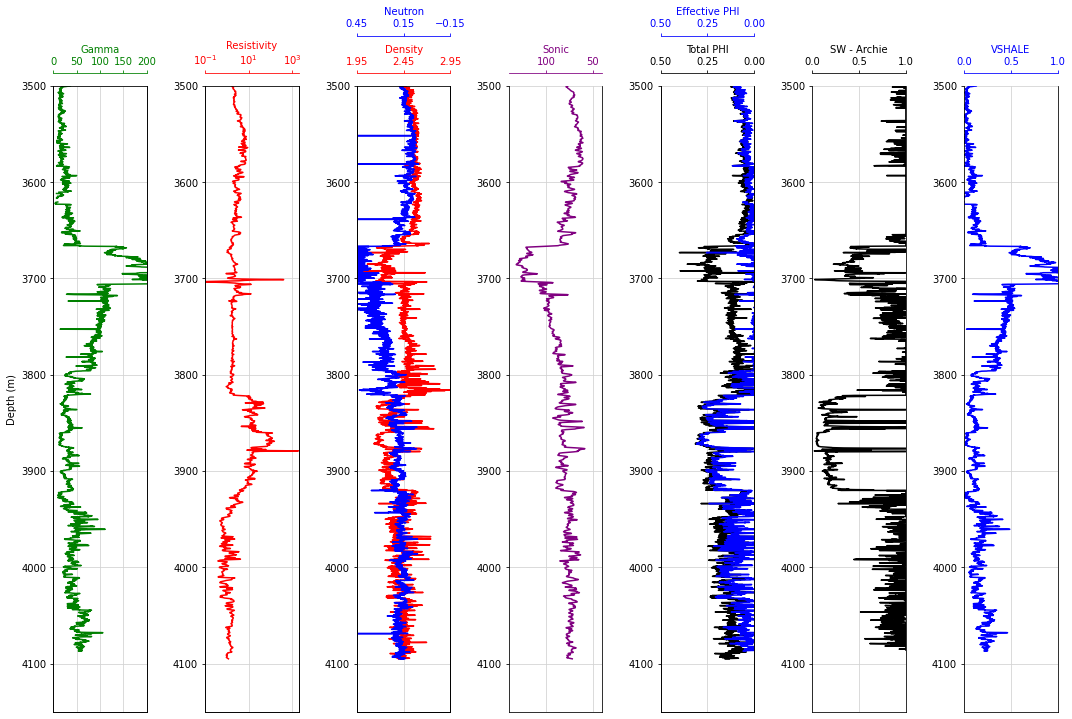

In [71]:
fig, ax = plt.subplots(figsize=(15,10)) #sets up the figure space

#Set up the plot axes (each axes being a plot)
ax1 = plt.subplot2grid((1,7), (0,0), rowspan=1, colspan = 1) # The first tuple defines that you want 1 row and 7 columns, and the second tuple defines the position of the particular plot (axes)
ax2 = plt.subplot2grid((1,7), (0,1), rowspan=1, colspan = 1)
ax3 = plt.subplot2grid((1,7), (0,2), rowspan=1, colspan = 1)
ax4 = plt.subplot2grid((1,7), (0,3), rowspan=1, colspan = 1)
ax5 = ax3.twiny() #Twins the y-axis for the density track with the neutron track
ax6 = plt.subplot2grid((1,7), (0,4), rowspan=1, colspan = 1)
ax7 = ax6.twiny()
ax8 = plt.subplot2grid((1,7), (0,5), rowspan=1, colspan = 1)
ax9 = plt.subplot2grid((1,7), (0,6), rowspan=1, colspan = 1)

# This gives some nice white space padding and borders (it's for visuals)
ax10 = ax1.twiny()
ax10.xaxis.set_visible(False)
ax11 = ax2.twiny()
ax11.xaxis.set_visible(False)
ax12 = ax3.twiny()
ax12.xaxis.set_visible(False)

# Gamma Ray track (AS YOU CAN SEE BELOW, ITS JUST SOME REPETITION OF THIS NEXT CHUNK)
ax1.plot("GR", "DEPTH", data = well, color = "green")
ax1.set_xlabel("Gamma")
ax1.xaxis.label.set_color("green")
ax1.set_xlim(0, 200)
ax1.set_ylabel("Depth (m)")
ax1.tick_params(axis='x', colors="green")
ax1.spines["top"].set_edgecolor("green")
ax1.title.set_color('green')
ax1.set_xticks([0, 50, 100, 150, 200])

# Resistivity track
ax2.plot("RT", "DEPTH", data = well, color = "red")
ax2.set_xlabel("Resistivity")
ax2.set_xlim(0.2, 2000)
ax2.xaxis.label.set_color("red")
ax2.tick_params(axis='x', colors="red")
ax2.spines["top"].set_edgecolor("red")
ax2.set_xticks([0.1, 1, 10, 100, 1000])
ax2.semilogx()

# Density track
ax3.plot("RHOB", "DEPTH", data = well, color = "red")
ax3.set_xlabel("Density")
ax3.set_xlim(1.95, 2.95)
ax3.xaxis.label.set_color("red")
ax3.tick_params(axis='x', colors="red")
ax3.spines["top"].set_edgecolor("red")
ax3.set_xticks([1.95, 2.45, 2.95])

# Sonic track
ax4.plot("DT", "DEPTH", data = well, color = "purple")
ax4.set_xlabel("Sonic")
ax4.set_xlim(140, 40)
ax4.xaxis.label.set_color("purple")
ax4.tick_params(axis='x', colors="purple")
ax4.spines["top"].set_edgecolor("purple")

# Neutron track placed ontop of density track
ax5.plot("NPHI", "DEPTH", data = well, color = "blue")
ax5.set_xlabel('Neutron')
ax5.xaxis.label.set_color("blue")
ax5.set_xlim(0.45, -0.15)
ax5.set_ylim(4150, 3500)
ax5.tick_params(axis='x', colors="blue")
ax5.spines["top"].set_position(("axes", 1.08))
ax5.spines["top"].set_visible(True)
ax5.spines["top"].set_edgecolor("blue")
ax5.set_xticks([0.45,  0.15, -0.15])

# Porosity track
ax6.plot("PHI", "DEPTH", data = well, color = "black")
ax6.set_xlabel("Total PHI")
ax6.set_xlim(0.5, 0)
ax6.xaxis.label.set_color("black")
ax6.tick_params(axis='x', colors="black")
ax6.spines["top"].set_edgecolor("black")
ax6.set_xticks([0, 0.25, 0.5])

# Porosity track
ax7.plot("PHIECALC", "DEPTH", data = well, color = "blue")
ax7.set_xlabel("Effective PHI")
ax7.set_xlim(0.5, 0)
ax7.xaxis.label.set_color("blue")
ax7.tick_params(axis='x', colors="blue")
ax7.spines["top"].set_position(("axes", 1.08))
ax7.spines["top"].set_visible(True)
ax7.spines["top"].set_edgecolor("blue")
ax7.set_xticks([0, 0.25, 0.5])

# Sw track
ax8.plot("SW_LIM", "DEPTH", data = well, color = "black")
ax8.set_xlabel("SW - Archie")
ax8.set_xlim(0, 1)
ax8.xaxis.label.set_color("black")
ax8.tick_params(axis='x', colors="black")
ax8.spines["top"].set_edgecolor("black")
ax8.set_xticks([0, 0.5, 1])

# VSH track
ax9.plot("VSHALE", "DEPTH", data = well, color = "blue")
ax9.set_xlabel("VSHALE")
ax9.set_xlim(0, 1)
ax9.xaxis.label.set_color("blue")
ax9.tick_params(axis='x', colors="blue")
ax9.spines["top"].set_edgecolor("blue")
ax9.set_xticks([0, 0.5, 1])

# Common functions for setting up the plot can be extracted into a for loop. This saves repeating code. 
# Here the y-axis set up and labels is being looped through for every one of the curves because it was the same. 
# The x-axis for each curve was different for each so that's why this only loops through the y axis.
for ax in [ax1, ax2, ax3, ax4, ax6, ax8, ax9]:
    ax.set_ylim(4150, 3500)
    ax.grid(which='major', color='lightgrey', linestyle='-')
    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("top")
    ax.spines["top"].set_position(("axes", 1.02))
    
    
plt.tight_layout()

Look at that plot!

# Using machine learning for petrophysics

There is a fast growing body of work on using machine learning in subsurface analysis and particulary in petrophysics. One area where ML can be particularly helpful is in identiging patterns across complex multi-dimensional data, such as grouping lithologies based on petrophysical propeties. For lithofacies identification, the two main types of ML that are applicable to petrophysical propeties are:
1. **Unsupervised classification** - the algorithm identifies underlying patterns in the data without you presenting labels for it to learn from. (ex. Kmeans)
2. **Supervised classification**, where an algorithm is presented data, from which it learns underlying data patterns and then seeks those out to class new data.

Let's build on an example that was worked up participants in a competeition put on by XEEK and FORCE and also worked up by [Andy McDonald](https://www.andymcdonald.scot). We're going to try and simplify the workflow!

Let's reuse the Xeek / FORCE 2020 (https://doi.org/10.5281/zenodo.4351155) that was put together for machine learning. The dataset consists of 118 wells from the Norwegian Sea.


### Unsupervised facies classification with K Means Clustering

In [72]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.colors as colors

In [73]:
#Load Force ML facies dataset
df = pd.read_csv(r"gdrive/My Drive/Data/xeek_train_subset.csv")
df.head()

WELL  DEPTH_MD         X_LOC      Y_LOC       Z_LOC         GROUP  \
0  15/9-13   494.528  437641.96875  6470972.5 -469.501831  NORDLAND GP.   
1  15/9-13   494.680  437641.96875  6470972.5 -469.653809  NORDLAND GP.   
2  15/9-13   494.832  437641.96875  6470972.5 -469.805786  NORDLAND GP.   
3  15/9-13   494.984  437641.96875  6470972.5 -469.957794  NORDLAND GP.   
4  15/9-13   495.136  437641.96875  6470972.5 -470.109772  NORDLAND GP.   

  FORMATION       CALI  RSHA      RMED  ...        ROP  DTS  DCAL      DRHO  \
0       NaN  19.480835   NaN  1.611410  ...  34.636410  NaN   NaN -0.574928   
1       NaN  19.468800   NaN  1.618070  ...  34.636410  NaN   NaN -0.570188   
2       NaN  19.468800   NaN  1.626459  ...  34.779556  NaN   NaN -0.574245   
3       NaN  19.459282   NaN  1.621594  ...  39.965164  NaN   NaN -0.586315   
4       NaN  19.453100   NaN  1.602679  ...  57.483765  NaN   NaN -0.597914   

   MUDWEIGHT  RMIC  ROPA  RXO  FORCE_2020_LITHOFACIES_LITHOLOGY  \
0        NaN   NaN   NaN  NaN                             65000   
1        NaN   NaN   NaN  NaN                             65000   
2        NaN   NaN   NaN  NaN                             65000   
3        NaN   NaN   NaN  NaN                             65000   
4        NaN   NaN   NaN  NaN                             65000   

   FORCE_2020_LITHOFACIES_CONFIDENCE  
0                                1.0  
1                                1.0  
2                                1.0  
3                                1.0  
4                                1.0  

[5 rows x 29 columns]

There are a lot of things in that data set, let's create a new dataframe that only has the data we want and rename some columns to make it simpler

In [74]:
#making a new DF that is the copy of the original, but only certain column are copied over.
workingdf = df[["WELL", "DEPTH_MD", "RDEP", "RHOB", "GR", "NPHI", "PEF", "DTC", "FORCE_2020_LITHOFACIES_LITHOLOGY"]].copy() #Making a copy of the dataframe with only the columns we want
workingdf.rename(columns={'FORCE_2020_LITHOFACIES_LITHOLOGY':'FACIES'}, inplace=True) # let's rename this column (note the FROM : TO) and lock the renaming in place.
workingdf.head()


WELL  DEPTH_MD      RDEP      RHOB         GR  NPHI        PEF  \
0  15/9-13   494.528  1.798681  1.884186  80.200851   NaN  20.915468   
1  15/9-13   494.680  1.795641  1.889794  79.262886   NaN  19.383013   
2  15/9-13   494.832  1.800733  1.896523  74.821999   NaN  22.591518   
3  15/9-13   494.984  1.801517  1.891913  72.878922   NaN  32.191910   
4  15/9-13   495.136  1.795299  1.880034  71.729141   NaN  38.495632   

          DTC  FACIES  
0  161.131180   65000  
1  160.603470   65000  
2  160.173615   65000  
3  160.149429   65000  
4  160.128342   65000

Now, just like we did in Session 3, let's relate the dictionary so that we can have some facies desciptions instead of long numbers.

In [75]:
# Creating a dictionarity that contains keys (FACIES codes) and the value (string facies desriptions) 
lithology_numbers = {30000: 'Sandstone',
                 65030: 'Sandstone/Shale',
                 65000: 'Shale',
                 80000: 'Marl',
                 74000: 'Dolomite',
                 70000: 'Limestone',
                 70032: 'Chalk',
                 88000: 'Halite',
                 86000: 'Anhydrite',
                 99000: 'Tuff',
                 90000: 'Coal',
                 93000: 'Basement'}

Let's create a second dictionary, that does the same thing but creates a simple integer code for each facies.

In [76]:
# Creating a dictionarity that contains keys (FACIES codes) and small values to make plotting easier 
simple_lithology_numbers = {30000: 1,
                 65030: 2,
                 65000: 3,
                 80000: 4,
                 74000: 5,
                 70000: 6,
                 70032: 7,
                 88000: 8,
                 86000: 9,
                 99000: 10,
                 90000: 11,
                 93000: 12}

So now let's create new columns that use those dictionaries to link facies codes to descriptions and simple lith codes. As a results we'll have column for the original FACIES (original lithology code/label), LITH (lithology description label), and LITH_SI (single integer lithology code/label)

In [77]:
# Create a column mapping our lithology descriptions to the Facies column
workingdf['LITH'] = workingdf['FACIES'].map(lithology_numbers)

# Create a column mapping our "simple lith codes" to the Facies column
workingdf['LITH_SI'] = workingdf['FACIES'].map(simple_lithology_numbers)

Now let's use a great block of code from Andy McDonald that takes the long figure lay out we used earlier, and makes it a function! 

This function defines the visual plot we'll see to show logs and our ML classified facies!

In [78]:
#defining a function that will create the plot.

#the function will be callsed "create_plot" and use paramters for well name, the dataframe, the curves we want to plot, the depth curve.
def create_plot(wellname, dataframe, curves_to_plot, depth_curve, log_curves=[], facies_curves=[]):
    # Count the number of tracks we need based on the curves we'll call later
    num_tracks = len(curves_to_plot)
    
    facies_color = ['#F4D03F', '#F5B041','#DC7633','#6E2C00', '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D', 'red','black', 'blue'] #this sets some facies colors to be used
    
            
    # Setup the figure and axes
    fig, ax = plt.subplots(nrows=1, ncols=num_tracks, figsize=(num_tracks*2, 10))
    
    # Create a title for the entire plot
    fig.suptitle(wellname, fontsize=20, y=1.05)
    
    # Loop through each curve in curves_to_plot and create a track with that data (this is the long code we avoid having to copy over from the previous example)
    for i, curve in enumerate(curves_to_plot): #for each curve that's called
        if curve in facies_curves:
            cmap_facies = colors.ListedColormap(facies_color[0:dataframe[curve].max()], 'indexed') #create a facies color bar
            
            cluster=np.repeat(np.expand_dims(dataframe[curve].values,1), 100, 1)
            im=ax[i].imshow(cluster, interpolation='none', cmap=cmap_facies, aspect='auto',vmin=dataframe[curve].min(),vmax=dataframe[curve].max(), 
                            extent=[0,20, depth_curve.max(), depth_curve.min()])
        
        else:
            ax[i].plot(dataframe[curve], depth_curve)

        
        # Setup a few plot cosmetics
        ax[i].set_title(curve, fontsize=14, fontweight='bold')
        ax[i].grid(which='major', color='lightgrey', linestyle='-')
        
        # We want to pass in the deepest depth first, so we are displaying the data from shallow to deep to set up the y-axis
        ax[i].set_ylim(depth_curve.max(), depth_curve.min())
#         ax[i].set_ylim(3500, 3000)

        # Only set the y-label for the first track. Hide it for the rest
        if i == 0:
            ax[i].set_ylabel('DEPTH (m)', fontsize=18, fontweight='bold')
        else:
            plt.setp(ax[i].get_yticklabels(), visible = False)
        
        # Check to see if we have any logarithmic scaled curves
        if curve in log_curves:
            ax[i].set_xscale('log')
            ax[i].grid(which='minor', color='lightgrey', linestyle='-')
        

    
    plt.tight_layout()
    plt.show()
    
    return cmap_facies

Now let's create a function that groups the dataframe using the `Groupby` function we previously discussed!

Here this will be used to split the dataframe into individual well dataframes that can be called faster for plotting!

In [79]:
# this function is being put together for plotting

def well_splitter(dataframe, groupby_column): #splits the large dataframe that includes multiple wells into individual dataframes for each well
    grouped = dataframe.groupby(groupby_column)
    
    # Create empty lists that will be filled as we call wells
    wells_as_dfs = []
    wells_wellnames = []

    #Split up the data by well
    for well, data in grouped:
        wells_as_dfs.append(data)
        wells_wellnames.append(well)

    print('index  wellname')
    for i, name in enumerate(wells_wellnames):
        print(f'{i}      {name}')
    
    return wells_as_dfs, wells_wellnames

The Kmeans clustering will be done on the whole working dataframe we created at the beginning (for all the wells) - for visualizing, let's break Groupby into wells for easier plotting.

In [80]:
#Lets run the function and print out the names of wells in the data set being used
grouped_wells, grouped_names = well_splitter(workingdf, 'WELL')

index  wellname
0      15/9-13
1      15/9-15
2      15/9-17
3      16/1-2
4      16/1-6 A
5      16/10-1
6      16/10-2
7      16/10-3
8      16/10-5
9      16/11-1 ST3
10      16/2-11 A
11      16/2-16


Now we'll import [Sci-kit learn](https://scikit-learn.org/stable/), a very powerful library that contains lots of ML functionality. In particular we'll pull in the Kmeans functions.

In [81]:
# Now let's import the Kmeans functions from Sci-kit learn.
from sklearn.cluster import KMeans #from the library sci kit learn, and the sublibrary cluster, pull in the Kmeans functions

In [82]:
# Dropping NaNs from our dataset to we only use rows with values for each curve
workingdf.dropna(inplace=True)

Now let's the function to find 5 clusters / facies in our data!

In [83]:
# Create the KMeans model with the selected number of clusters
kmeans = KMeans(n_clusters=5)

# Fit the model to our dataset
kmeans.fit(workingdf[['GR', 'RHOB', 'NPHI', 'DTC']]) # the kmeans.fit function is identifying clusters across the logs we choose

# Assign the data back to the workingdf
workingdf['KMeans'] = kmeans.labels_ #the resulting Kmeans facies identified are stored in a new column called "KMeans"

The Kmeans classification above was done on the whole classification, now let's reuse the function that was written to split the data into invidial well dataframes so that we can plot them easier!

In [84]:
dfs_wells, wellnames = well_splitter(workingdf, 'WELL') # let's run that function that was grouping wells by name

index  wellname
0      15/9-13
1      15/9-15
2      15/9-17
3      16/1-6 A
4      16/10-1
5      16/10-2
6      16/10-3
7      16/10-5
8      16/2-11 A
9      16/2-16


Now again, the power of Python is that code that be saved and re-used. Let's use the awesome well plot function Andy defined to use it to plot the results! 

As you can see from the kmeans log, the general patterns of what facies are being broken out align very nicely with actual rock classifications!

Note the colors don't have to match - it's more about to the vertical changes in facies align!

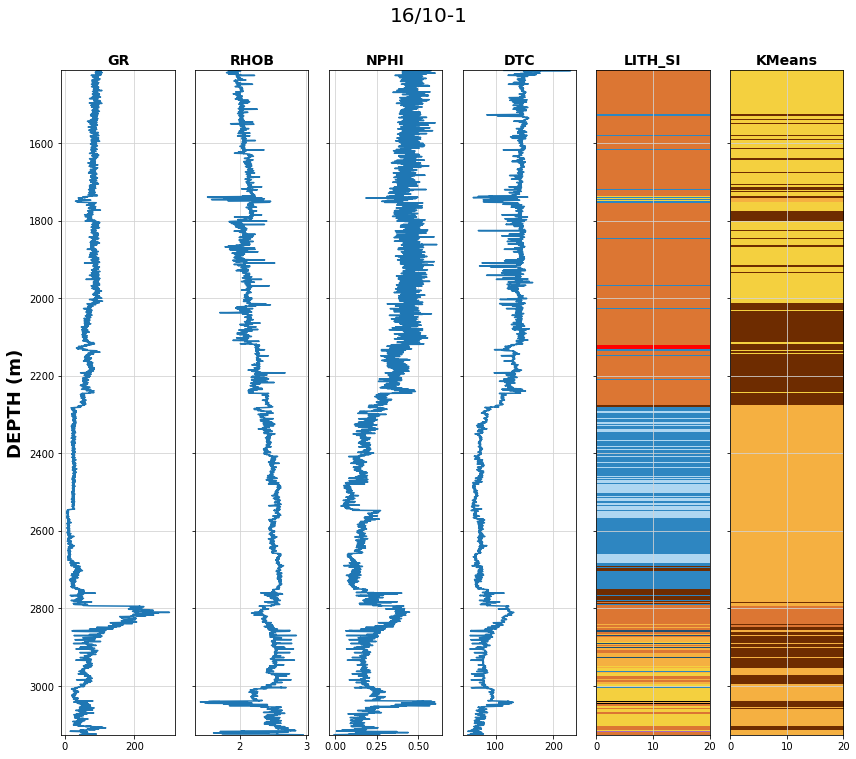

In [85]:
# Setup the curves to plot
curves_to_plot = ['GR', 'RHOB', 'NPHI', 'DTC',  'LITH_SI', 'KMeans'] #choosing the curves we want to plot
logarithmic_curves = ['RDEP'] # stating RDEP should be a in log space
facies_curve=['KMeans','LITH_SI'] # defining which curves are the facies curves

# Create plot by passing in the relevant well index number
well = 4 #choosing well 4. Try changing it - this is why we made the well groupby function
cmap_facies = create_plot(wellnames[well], # Defining the color map to use based on
            dfs_wells[well], # selecting a well
            curves_to_plot, # selecting the curves that will be visualized
            dfs_wells[well]['DEPTH_MD'], 
            logarithmic_curves, facies_curve)

How nice of a plot is that? As you can see there is some nice alignment between the vertical facies changes!
Now let's see if we do a scatter plot to see how the actual facies compare to the kmeans facies

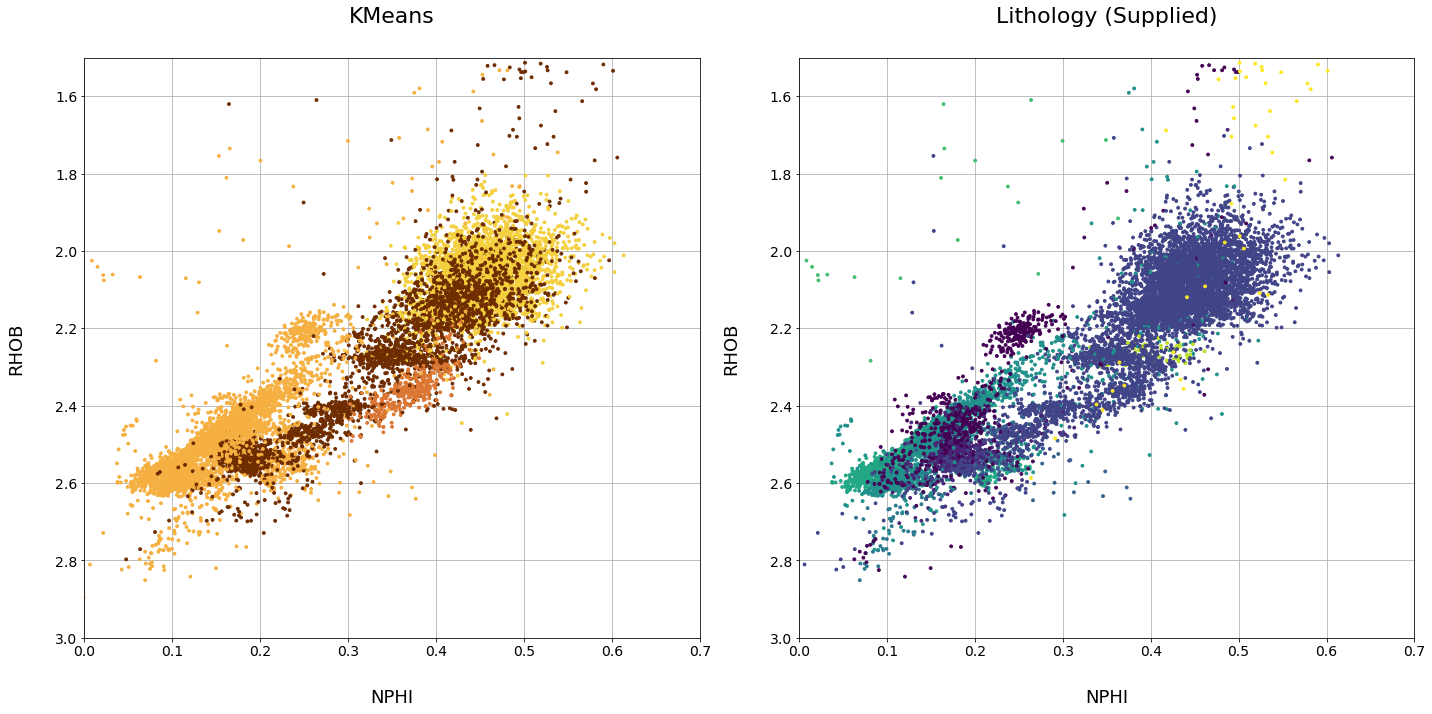

In [86]:
# defining the figure space
fig, ax = plt.subplots(figsize=(20,10))

#Creating the first plot which will be colored by our Kmeans facies
ax1 = plt.subplot2grid((1,2), (0,0)) #definign a plot that has one row and two columns
ax1.scatter(dfs_wells[well]['NPHI'], dfs_wells[well]['RHOB'], c=dfs_wells[well]['KMeans'], s=8, cmap=cmap_facies) #using the scatter function and plotting NPHI vs RHOB colored by Kmeans facies
ax1.set_title('KMeans', fontsize=22, y=1.05)

#Creating the second scatter plot that will be colored by actual lithology from the dataset
ax2 = plt.subplot2grid((1,2), (0,1)) #defining the second plot for the second column
ax2.scatter(dfs_wells[well]['NPHI'], dfs_wells[well]['RHOB'], c=dfs_wells[well]['LITH_SI'], s=8) #using the scatter function and plotting NPHI vs RHOB colored by actual lithology
ax2.set_title('Lithology (Supplied)', fontsize=22, y=1.05)

# defining a function that makes making axis lables nicer
for ax in [ax1, ax2]:
    ax.set_xlim(0, 0.7)
    ax.set_ylim(3, 1.5)
    ax.set_ylabel('RHOB', fontsize=18, labelpad=30)
    ax.set_xlabel('NPHI', fontsize=18, labelpad=30)
    ax.grid()
    ax.set_axisbelow(True)

    ax.tick_params(axis='both', labelsize=14)

plt.tight_layout()

Congratulations, you've just run through two great examples of what python can do for us, specifically:
- Allows incredible data manipulation
- Allows someone to make great visuals/plots
- Libraries are chunks of code that have been written and wrapped
- Just like when you re-used codes others have put together, or copied those codes over, that's essentiallly what you are doing when you are calling a library!

We hope these examples you've seen throughout the course really re-inforce that! Python is increbily powerful and really boosts what you can do with Python alone or when you start thinking of integrating Python with Spotfire, StarSteer, etc...